## Housing Market Analysis

### Step 1: Import Libraries

In [2]:
import zipfile
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import xgboost as xgb

### Step 2: Read Data

In [3]:
# Unzipping the file
with zipfile.ZipFile('Housing_price.zip', 'r') as zip_ref:
    zip_ref.extractall('Housing_price')

# Get list of all files in the extracted folder
file_list = os.listdir('Housing_price')

# Load the first CSV file into a DataFrame
csv_file = [file for file in file_list if file.endswith('.csv')][0]
df = pd.read_csv(f'Housing_price/{csv_file}')

# Display the first few rows to inspect the data
print(df.head())

   SquareFeet  Bedrooms  Bathrooms Neighborhood  YearBuilt          Price
0        2126         4          1        Rural       1969  215355.283618
1        2459         3          2        Rural       1980  195014.221626
2        1860         2          1       Suburb       1970  306891.012076
3        2294         2          1        Urban       1996  206786.787153
4        2130         5          2       Suburb       2001  272436.239065


### Step 3: Initial Data Exploration

In [4]:
# Check the basic information and data types of each column
print("\nData Types and Non-Null Counts:\n")
print(df.info())

# Check for missing values
print("\nMissing Values:\n")
print(df.isnull().sum())

# View basic statistics of numerical columns
print("\nSummary Statistics for Numerical Columns:\n")
print(df.describe())

# Display unique values in categorical columns
categorical_columns = df.select_dtypes(include='object').columns
for col in categorical_columns:
    print(f"\nUnique values in '{col}':")
    print(df[col].unique())

# Check for duplicate rows
duplicates = df[df.duplicated()]
print(f"\nNumber of duplicate rows: {len(duplicates)}")


Data Types and Non-Null Counts:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SquareFeet    50000 non-null  int64  
 1   Bedrooms      50000 non-null  int64  
 2   Bathrooms     50000 non-null  int64  
 3   Neighborhood  50000 non-null  object 
 4   YearBuilt     50000 non-null  int64  
 5   Price         50000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 2.3+ MB
None

Missing Values:

SquareFeet      0
Bedrooms        0
Bathrooms       0
Neighborhood    0
YearBuilt       0
Price           0
dtype: int64

Summary Statistics for Numerical Columns:

         SquareFeet      Bedrooms     Bathrooms     YearBuilt          Price
count  50000.000000  50000.000000  50000.000000  50000.000000   50000.000000
mean    2006.374680      3.498700      1.995420   1985.404420  224827.325151
std      575.513241      1.116326

### Step 4: Data Cleaning and Preprocessing

In [5]:
# Drop rows with missing target values (e.g., Price)
df.dropna(subset=['Price'], inplace=True)

# Remove outliers in the target variable using the 1.5 IQR rule
q1 = df['Price'].quantile(0.25)
q3 = df['Price'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
df = df[(df['Price'] >= lower_bound) & (df['Price'] <= upper_bound)]

# Feature Engineering
# Create new features
df['HomeAge'] = 2023 - df['YearBuilt']  # Age of the house
df['SqFtPerRoom'] = df['SquareFeet'] / (df['Bedrooms'] + df['Bathrooms'])  # Square feet per room

# Log-transform the target variable to reduce skewness
df['LogPrice'] = np.log(df['Price'])

# Encode categorical variables
df = pd.get_dummies(df, columns=['Neighborhood'], drop_first=True)

### Step 5: Model Training

In [6]:
# Feature Selection for Predictive Modeling
target = 'LogPrice'  # Adjusted to reflect the correct target column
features = [col for col in df.columns if col != target and col != 'Price']  # Exclude 'Price' from features
X = df[features]
y = df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing steps for numerical and categorical features
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Handle missing values
    ('scaler', StandardScaler())  # Standardize numerical features
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', 'passthrough', categorical_features)  # Categorical features are already encoded
    ])

# Define models to compare
models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(random_state=42)
}

### Step 6: Training the Model

In [7]:
# Train and evaluate models
results = {}
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Fit the model
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred = pipeline.predict(X_test)
    y_pred_exp = np.exp(y_pred)  # Inverse log transformation to get the predicted price
    y_test_exp = np.exp(y_test)  # Inverse log transformation to get the actual price
    
    # Evaluate the model
    mae = mean_absolute_error(y_test_exp, y_pred_exp)
    mse = mean_squared_error(y_test_exp, y_pred_exp)
    r2 = r2_score(y_test_exp, y_pred_exp)
    
    results[name] = {'MAE': mae, 'MSE': mse, 'R2': r2}
    
    print(f"\n{name} Model Performance:")
    print(f"Mean Absolute Error: {mae:.2f}")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"R^2 Score: {r2:.2f}")


RandomForest Model Performance:
Mean Absolute Error: 43676.06
Mean Squared Error: 2954020354.09
R^2 Score: 0.48

GradientBoosting Model Performance:
Mean Absolute Error: 40409.45
Mean Squared Error: 2533948859.60
R^2 Score: 0.56

XGBoost Model Performance:
Mean Absolute Error: 41263.09
Mean Squared Error: 2644843950.31
R^2 Score: 0.54


### Step 7: Compare Performance

In [11]:
# Compare model performance
results_df = pd.DataFrame(results).T
print("\nModel Comparison:")
print(results_df)

# Feature Importance (using the best-performing model)
best_model = models['GradientBoosting']  # Replace with the best-performing model

# Fit the preprocessor and transform the training data
X_train_transformed = preprocessor.fit_transform(X_train)

# Fit the best model on the transformed data
best_model.fit(X_train_transformed, y_train)


Model Comparison:
                           MAE           MSE        R2
RandomForest      43676.056366  2.954020e+09  0.481637
GradientBoosting  40409.450363  2.533949e+09  0.555350
XGBoost           41263.091446  2.644844e+09  0.535890


GradientBoostingRegressor(random_state=42)

### Step 8: Feature Importance

C:\Users\milto\AppData\Local\Temp\ipykernel_13396\2546777707.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')


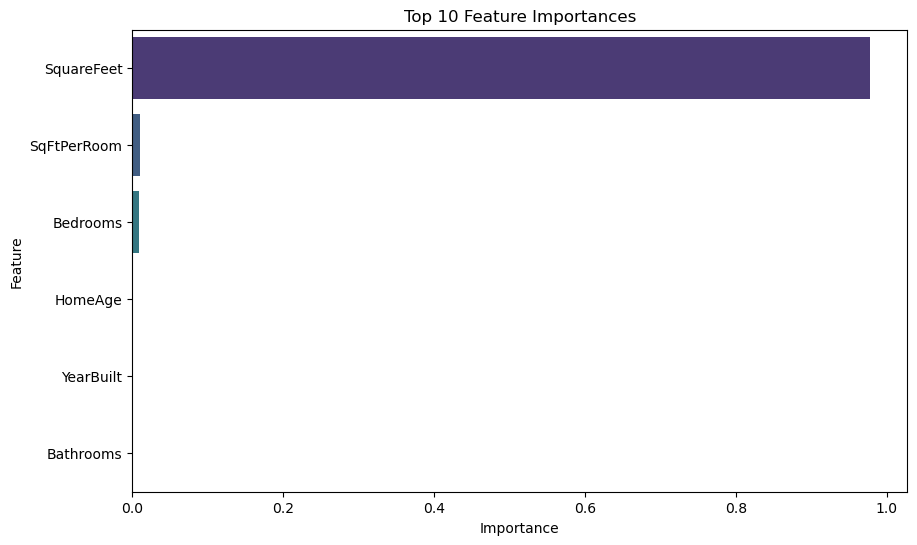

In [12]:
# Get feature importances
importances = best_model.feature_importances_

# Get feature names after preprocessing
# Since categorical features are already one-hot encoded, we need to align feature names with the transformed data
# Numerical features are scaled, and categorical features are passed through
feature_names = numerical_features.tolist()  # Numerical features
if 'cat' in preprocessor.named_transformers_:
    # Add categorical feature names (already one-hot encoded)
    feature_names.extend(X[categorical_features].columns.tolist())

# Ensure the lengths match
if len(feature_names) != len(importances):
    raise ValueError(f"Mismatch in lengths: {len(feature_names)} feature names vs {len(importances)} importances")

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the top 10 feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')
plt.title('Top 10 Feature Importances')
plt.show()